In [1]:
!pip install ultralytics
!pip install torchtoolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

In [2]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torch.nn import MultiheadAttention
from torchvision import transforms
from PIL import Image
import random
import os
from torch.utils.data import Dataset, DataLoader, Sampler, Subset, SubsetRandomSampler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtoolbox.tools import mixup_data, mixup_criterion
from torch.utils.data import random_split

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

In [4]:
CHARACTERS = [
    "皖","沪","津","渝","冀","晋","蒙","辽","吉","黑","苏","浙","京","闽","赣","鲁","豫","鄂","湘","粤","桂","琼","川","贵","云","藏","陕","甘","青","宁","新","警","学","O",
    "A","B","C","D","E","F","G","H","J","K","L","M","N","P","Q","R","S","T","U","V","W","X","Y","Z",
    "0","1","2","3","4","5","6","7","8","9"]
SOS_TOKEN = len(CHARACTERS)  # SOS token là chỉ số ngay sau ký tự cuối cùng
EOS_TOKEN = len(CHARACTERS) + 1
PAD_TOKEN = len(CHARACTERS) + 2
NUM_CLASSES = len(CHARACTERS) + 3  # Tổng số lớp: ký tự + SOS + EOS + PAD
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#--- Utility functions ---
def index_to_char(indices, include_special_tokens=False):
    result = []
    for i in indices:
        i = i.item() if torch.is_tensor(i) else i
        if i == SOS_TOKEN:
            if include_special_tokens: result.append('[SOS]')
        elif i == EOS_TOKEN:
            if include_special_tokens: result.append('[EOS]')
            break
        elif 0 <= i < len(CHARACTERS):
            result.append(CHARACTERS[i])
        else:
            if include_special_tokens or i not in [SOS_TOKEN, EOS_TOKEN]:
                result.append(f'[UNK_{i}]')
    return ''.join(result)

def char_to_indices(text):
    indices = [SOS_TOKEN]
    for c in text:
        if c in CHARACTERS:
            indices.append(CHARACTERS.index(c))
    indices.append(EOS_TOKEN)
    return torch.tensor(indices, dtype=torch.long)

#--- Early Stopping ---
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, monitor_metric='val_acc', mode='max', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.monitor_metric = monitor_metric
        self.mode = mode
        self.verbose = verbose

        if self.mode == 'min':
            self.best_metric_val = np.Inf
        else:
            self.best_metric_val = -np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_metric_val):
        improved = False
        if self.mode == 'min':
            if current_metric_val < self.best_metric_val - self.min_delta:
                self.best_metric_val = current_metric_val
                improved = True
        else:
            if current_metric_val > self.best_metric_val + self.min_delta:
                self.best_metric_val = current_metric_val
                improved = True
        
        if improved:
            self.counter = 0
            if self.verbose:
                print(f"EarlyStopping: New best {self.monitor_metric}: {self.best_metric_val:.4f}")
        else:
            self.counter += 1

        if self.verbose and self.counter > 0 and not improved:
            print(f"EarlyStopping counter: {self.counter}/{self.patience} (Best {self.monitor_metric}: {self.best_metric_val:.4f})")
        if self.counter >= self.patience:
            self.early_stop = True
            if self.verbose:
                print(f"Early stopping triggered for {self.monitor_metric}.")
        return self.counter

In [5]:
#--- YOLO ---
class YoloBackbone(nn.Module):
    def __init__(self, model_path, target_feature_layer_index=9):
        super().__init__()
        _temp_yolo_instance = YOLO(model_path)
        self.yolo_detection_model = _temp_yolo_instance.model
        self.yolo_detection_model.to(DEVICE)
        self.target_feature_layer_index = target_feature_layer_index

        for name, param in self.yolo_detection_model.named_parameters():
            param.requires_grad = True
        
        self._hook_handle = None
        self._fmap_out_hook = []
        
        self._register_hook()

    def _hook_fn_extractor(self, module, input_val, output_val):
        if isinstance(output_val, torch.Tensor):
            self._fmap_out_hook.append(output_val)
        elif isinstance(output_val, (list, tuple)):
            for item in output_val:
                if isinstance(item, torch.Tensor):
                    self._fmap_out_hook.append(item)
                    break

    def _register_hook(self):
        layer_to_hook = self.yolo_detection_model.model[self.target_feature_layer_index]
        self._hook_handle = layer_to_hook.register_forward_hook(self._hook_fn_extractor)

    def _remove_hook(self):
        if self._hook_handle:
            self._hook_handle.remove()
            self._hook_handle = None

    def forward(self, x):
        self._fmap_out_hook.clear()
        _ = self.yolo_detection_model(x)
        out_tensor = self._fmap_out_hook[0]
        return out_tensor if out_tensor.dim() == 4 else out_tensor.unsqueeze(0)

In [6]:
#--- RViT ---
class RViT(nn.Module):
    def __init__(self, yolo_channels=256, d_model=512, num_patches=1600, n_heads=8, num_encoder_layers=3, dim_feedforward=2048, dropout_rate=0.3):
        super().__init__()
        self.d_model = d_model
        self.proj = nn.Sequential(
            nn.Conv2d(yolo_channels, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate if dropout_rate > 0 else 0)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=dim_feedforward,
            dropout=dropout_rate, batch_first=True, norm_first=False
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        self.region_q = nn.Parameter(torch.zeros(1, 1, d_model))
        
        self.embed = nn.Embedding(NUM_CLASSES, d_model)
        self.gru_num_layers = 1
        self.gru = nn.GRU(d_model, d_model, num_layers=self.gru_num_layers, batch_first=True,
                          dropout=dropout_rate if self.gru_num_layers > 1 else 0)
        self.attn = MultiheadAttention(d_model, num_heads=n_heads, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate if dropout_rate > 0 else 0),
            nn.Linear(2 * d_model, NUM_CLASSES)
        )

    def forward(self, fmap, target=None, teach_ratio=0.5, forced_output_length=None):
        b = fmap.size(0)
        x = self.proj(fmap)
        x = x.flatten(2).permute(0, 2, 1)

        current_num_patches = x.size(1)
        expected_pos_embed_len = current_num_patches + 1
        
        if self.pos_embed.size(1) != expected_pos_embed_len:
            if self.pos_embed.size(1) > expected_pos_embed_len:
                pos_embed_to_add = self.pos_embed[:, :expected_pos_embed_len, :]
            else:
                raise ValueError(f"RViT pos_embed second dim {self.pos_embed.size(1)} is smaller than required {expected_pos_embed_len}")
        else:
            pos_embed_to_add = self.pos_embed

        q = self.region_q.expand(b, -1, -1)
        x = torch.cat([q, x], dim=1)
        x = x + pos_embed_to_add

        enc = self.encoder(x)
        region_feat, spatial_feats = enc[:, 0], enc[:, 1:]
        
        if forced_output_length is not None:
            max_gen_len = forced_output_length
        elif target is not None:
            max_gen_len = target.size(1) - 1
        else:
            max_gen_len = MAX_SEQ_LENGTH - 1

        h = region_feat.unsqueeze(0).contiguous()
        current_input_tokens = torch.full((b,), SOS_TOKEN, device=DEVICE, dtype=torch.long)
        outputs_logits = []

        finished_sequences_tracker = None
        if target is None and forced_output_length is None:
            finished_sequences_tracker = torch.zeros(b, dtype=torch.bool, device=DEVICE)
            
        for t in range(max_gen_len):
            emb = self.embed(current_input_tokens).unsqueeze(1)
            g, h = self.gru(emb, h)
            a, _ = self.attn(g, spatial_feats, spatial_feats)
            comb = torch.cat([g.squeeze(1), a.squeeze(1)], dim=-1)
            logits_step = self.fc(comb)
            outputs_logits.append(logits_step)

            if target is not None and random.random() < teach_ratio:
                next_input_candidate = target[:, t + 1]
            else:
                next_input_candidate = logits_step.argmax(-1)

            if finished_sequences_tracker is not None:
                eos_predicted_this_step = (next_input_candidate == EOS_TOKEN)
                finished_sequences_tracker |= eos_predicted_this_step
                current_input_tokens = torch.where(finished_sequences_tracker,
                                                 torch.tensor(EOS_TOKEN, device=DEVICE, dtype=torch.long),
                                                 next_input_candidate)
                if finished_sequences_tracker.all():
                    break
            else:
                current_input_tokens = next_input_candidate
        
        return torch.stack(outputs_logits, dim=1)

In [7]:
#--- YOLO_RViT ---
class YOLO_RViT(nn.Module):
    def __init__(self, yolo_path, yolo_target_feature_layer_idx=9):
        super().__init__()
        self.backbone = YoloBackbone(yolo_path, target_feature_layer_index=yolo_target_feature_layer_idx)
        dummy_input = torch.randn(1, 3, 640, 640).to(DEVICE)
        
        original_backbone_training_mode = self.backbone.training
        with torch.no_grad():
            dummy_feats = self.backbone(dummy_input)
        
        yolo_channels = dummy_feats.shape[1]
        h_feat, w_feat = dummy_feats.shape[2], dummy_feats.shape[3]
        num_patches = h_feat * w_feat
        
        self.rvit = RViT(yolo_channels=yolo_channels, num_patches=num_patches).to(DEVICE)

    def forward(self, x, target=None, teach_ratio=0.5, forced_output_length=None):
        x = x.to(DEVICE)
        feats = self.backbone(x)
        return self.rvit(feats, target, teach_ratio, forced_output_length)

    def train(self, mode: bool = True):
        super().train(mode)
        self.rvit.train(mode)
        self.backbone.train(mode)
        return self

    def eval(self):
        super().eval()
        self.rvit.eval()
        self.backbone.eval()
        return self

In [8]:
import albumentations as A
import cv2
import random
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 640
# Nếu dùng YOLO backbone -> False; nếu không thì True
NORMALIZE_FOR_BACKBONE = False

# Letterbox đặt CUỐI CÙNG để tránh lộ vùng đệm kỳ dị khi biến đổi hình học
_LETTERBOX_LAST = [
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE,
                  border_mode=cv2.BORDER_CONSTANT, fill=(114,114,114) , p=1.0),
    A.ToFloat(max_value=255.0),  # <-- thêm dòng này
]

def _maybe_norm(normalize: bool):
    return [A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))] if normalize else []

def make_ccpd_aug(subset: str, img_size=IMG_SIZE, normalize=False):
    # ----- từng chủ đề/subnet -----
    if subset == "base":
        t = [
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15),
                A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.12, hue=0.03),
            ], p=0.6),
            A.GaussNoise(std_range=(0.005, 0.015), mean_range=(0.0,0.0), p=0.3),
        ]
    elif subset == "db":  # Dark & Bright
        t = [
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.45, contrast_limit=0.35),
                A.RandomGamma(gamma_limit=(60,160)),
            ], p=0.9),
            A.OneOf([
                A.RandomShadow(shadow_roi=(0.05,0.05,0.95,0.95),
                               num_shadows_limit=(1,1),          # hoặc (1,2) nếu muốn ngẫu nhiên 1–2 bóng
                               shadow_dimension=3,
                               shadow_intensity_range=(0.25,0.5)),
                A.RandomSunFlare(flare_roi=(0,0,1,0.8),
                                 num_flare_circles_range=(2,5),
                                 angle_range=(0.0,1.0),
                                 src_radius=60),
            ], p=0.35),
        ]
    elif subset == "blur":
        t = [
            A.OneOf([
                A.MotionBlur(blur_limit=(5,11)),
                A.GaussianBlur(blur_limit=(3,7)),
                A.GlassBlur(sigma=0.7, max_delta=3, iterations=1),
            ], p=0.9),
        ]
    elif subset == "fn":  # Far & Near
        t = [
            A.OneOf([
                A.Affine(scale=(0.55,0.75), translate_percent=(0.0,0.02),
                         rotate=(0,0), shear=(0,0),
                         interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST,
                         border_mode=cv2.BORDER_CONSTANT, fill=(114,114,114)),
                A.RandomResizedCrop(size=(img_size, img_size),
                                    scale=(0.80,1.00), ratio=(0.95,1.05),
                                    interpolation=cv2.INTER_LINEAR),
            ], p=0.9),
            A.OneOf([
                A.Downscale(scale_range=(0.60,0.85)),
                A.ImageCompression(quality_range=(40,70)),
            ], p=0.5),
        ]
    elif subset == "rotate":
        t = [
            A.Affine(rotate=(-15,15), scale=(0.95,1.05), translate_percent=(0.0,0.04),
                     shear=(0,0),
                     interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST,
                     border_mode=cv2.BORDER_CONSTANT, fill=(114,114,114), p=1.0),
        ]
    elif subset == "tilt":
        t = [
            A.Affine(scale=(0.95,1.05), translate_percent=(0.0,0.05),
                     rotate=(-3,3), shear=(-18,18),
                     interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST,
                     border_mode=cv2.BORDER_CONSTANT, fill=(114,114,114), p=0.8),
            A.Perspective(scale=(0.06,0.14), keep_size=True,
                          border_mode=cv2.BORDER_CONSTANT, fill=(114,114,114),
                          interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST, p=0.5),
        ]
    elif subset == "weather":
        t = [
            A.OneOf([
                A.RandomFog(fog_coef_range=(0.12,0.28), alpha_coef=0.06),
                A.RandomRain(slant_range=(-10,10), drop_length=14, blur_value=3),
                A.RandomSnow(snow_point_range=(0.10,0.30), brightness_coeff=1.5),
            ], p=0.9),
            A.ISONoise(color_shift=(0.01,0.05), intensity=(0.1,0.35), p=0.4),
        ]
    elif subset == "challenge":
        t = [
            A.OneOf([
                A.Affine(scale=(0.90,1.08), translate_percent=(0.0,0.06),
                         rotate=(-7,7), shear=(-15,15),
                         interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST,
                         border_mode=cv2.BORDER_CONSTANT, fill=(114,114,114)),
                A.Perspective(scale=(0.08,0.16), keep_size=True,
                              border_mode=cv2.BORDER_CONSTANT, fill=(114,114,114),
                              interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
            ], p=0.7),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.3),
                A.RandomGamma(gamma_limit=(70,140)),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=(3,9)),
                A.GaussianBlur(blur_limit=(3,7)),
            ], p=0.5),
            A.CoarseDropout(num_holes_range=(1,2),           # hoặc (1,3)
                            hole_height_range=(0.06,0.12),
                            hole_width_range=(0.06,0.12),
                            fill=0, p=0.12),
        ]
    else:
        raise ValueError(f"Unknown subset: {subset}")

    return A.Compose(
        [*t, *_LETTERBOX_LAST, *_maybe_norm(normalize), ToTensorV2()],
        strict=True
    )


class CCPDAugmenter:
    def __init__(self, img_size=IMG_SIZE, normalize=False, weights=None, fixed_subset=None):
        self.img_size = img_size
        self.normalize = normalize
        # phân phối gần giống “default test” của CCPD; bạn chỉnh tùy ý
        self.weights = weights or {
            "base": 0.01,
            "db": 0.20,        # cao
            "fn": 0.22,        # cao
            "rotate": 0.14,    # tăng nhẹ
            "tilt": 0.20,      # cao
            "weather": 0.01,
            "challenge": 0.22  # cao
        }
        self.fixed_subset = fixed_subset  # nếu muốn khóa 1 subnet

    def _sample_subset(self):
        if self.fixed_subset is not None:
            return self.fixed_subset
        names, probs = zip(*self.weights.items())
        return random.choices(names, weights=probs, k=1)[0]

    def __call__(self, image=None, **kwargs):
        if image is None:
            image = kwargs.get("image")
        subset = self._sample_subset()
        tf = make_ccpd_aug(subset, img_size=self.img_size, normalize=self.normalize)
        out = tf(image=image)
        # có thể gắn kèm tên subnet để debug:
        # out["subset"] = subset
        return out

# === Drop-in thay thế cho train_tf / val_tf trong code của bạn ===
train_tf = CCPDAugmenter(img_size=IMG_SIZE, normalize=NORMALIZE_FOR_BACKBONE)
val_tf = A.Compose([*_LETTERBOX_LAST, *(_maybe_norm(NORMALIZE_FOR_BACKBONE)), ToTensorV2()],
                   strict=True)
class LicensePlateDataset(Dataset):
    def __init__(self, img_dir, max_seq_length=15, is_train=True):
        self.img_dir = img_dir
        self.max_seq_length = max_seq_length
        self.img_names = [f for f in os.listdir(self.img_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.is_train = is_train
        self.transform = train_tf if is_train else val_tf
        
    def __len__(self):
        return len(self.img_names)
        
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        # print(img_name)
        
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Albumentations nhận ndarray
        img_np = np.array(img)
        img_tensor = self.transform(image=img_np)["image"]

        # import matplotlib.pyplot as plt

        # img_vis = img_tensor.detach().cpu().permute(1,2,0).numpy()  # (H,W,C)
        # img_vis = np.clip(img_vis, 0, 1)
        
        # plt.imshow(img_vis)
        # plt.axis('off')
        # plt.show()

        # Parse CCPD filename -> target (giữ logic của bạn)
        license_text_field = img_name.split("-")[-3]
        chars = license_text_field.split("_")
        license_text = [
            provinces[int(chars[0])],
            alphabets[int(chars[1])],
            ads[int(chars[2])],
            ads[int(chars[3])],
            ads[int(chars[4])],
            ads[int(chars[5])],
            ads[int(chars[6])]
        ]
        license_indices = char_to_indices(license_text)
        target = torch.full((self.max_seq_length,), PAD_TOKEN, dtype=torch.long)
        l = min(len(license_indices), self.max_seq_length)
        target[:l] = torch.as_tensor(license_indices[:l], dtype=torch.long)

        return img_tensor, target

    @staticmethod
    def collate_fn(batch):
        images = torch.stack([item[0] for item in batch])
        targets = torch.stack([item[1] for item in batch])
        return images, targets

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
# test = LicensePlateDataset("/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_base")
# test.__getitem__(0)

In [10]:
#--- Training ---
YOLO_MODEL_PATH = '/kaggle/input/m/thitenguyen/yolov11s/pytorch/default/1/best.pt'
YOLO_TARGET_FEATURE_LAYER_INDEX = 13

IMG_DIR_TRAIN = "/kaggle/input/ccpd-base-dataset/ccpd_base_dataset/images/train"
LICENSE_DIR_TRAIN = "/kaggle/input/dataset-lpr-test/License_plate_data2/text/train"
IMG_DIR_VAL = "/kaggle/input/ccpd-base-dataset/ccpd_base_dataset/images/val"
LICENSE_DIR_VAL = "/kaggle/input/dataset-lpr-test/License_plate_data2/text/val"

MAX_SEQ_LENGTH = 15
BATCH_SIZE = 32
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
MAX_LR_SCHEDULER = 5e-4
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 4
ACCUM_STEPS = 2
PATIENCE_EARLY_STOP = 100
TEACH_RATIO_START = 0.7
TEACH_RATIO_END = 0.05
LABEL_SMOOTHING = 0.01

scaler = torch.amp.GradScaler(DEVICE)
autocast_context = lambda: torch.amp.autocast(DEVICE)


model = YOLO_RViT(YOLO_MODEL_PATH, yolo_target_feature_layer_idx=YOLO_TARGET_FEATURE_LAYER_INDEX).to(DEVICE)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scheduler_type = "OneCycleLR"

loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN, label_smoothing=LABEL_SMOOTHING)
early_stopper = EarlyStopping(patience=PATIENCE_EARLY_STOP, min_delta=0.0005, monitor_metric='val_acc', mode='max', verbose=True)

checkpoint = torch.load("/kaggle/input/ccpd_base_good/pytorch/default/1/CCPD_BASE_GOOD.pth", map_location=DEVICE, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_values, val_loss_values = [], []
train_acc_values, val_acc_values, val_acc_constrained_values = [], [], []
epoch_count_list = []
best_val_acc = 0.0

TEST_FOLDERS = {
    "base": "/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_base", 
    "db":        "/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_db",
    "fn":        "/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_fn",
    "rotate":    "/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_rotate",
    "weather":   "/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_weather",
    "challenge": "/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_challenge",
    "tilt": "/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_tilt",
}

for name, path in TEST_FOLDERS.items():
    test_dataset = LicensePlateDataset(img_dir=path, max_seq_length=MAX_SEQ_LENGTH, is_train=False)
    if name == "challenge":
        test_dataset = Subset(test_dataset, torch.randperm(len(test_dataset)).tolist()[:10000])
    elif name == "fn":
        test_dataset = Subset(test_dataset, torch.randperm(len(test_dataset)).tolist()[:20000])
    elif name == "tilt":
        test_dataset = Subset(test_dataset, torch.randperm(len(test_dataset)).tolist()[:10000])
    elif name == "base":
        test_dataset = Subset(test_dataset, torch.randperm(len(test_dataset)).tolist()[:100000])
    elif name == "db":
        test_dataset = Subset(test_dataset, torch.randperm(len(test_dataset)).tolist()[:10000])
    
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=LicensePlateDataset.collate_fn, pin_memory=(DEVICE == 'cuda'))
    print(f"Test trên tập {name}: {len(test_dataset)}")

    # --- Validation Loop ---
    model.eval()
    val_loss, val_correct, val_total_chars, val_correct_constrained, val_total_sequences_constrained = 0, 0, 0, 0, 0
    pbar_val = tqdm(test_dataloader, desc=f"[TEST]")
    with torch.no_grad():
        for imgs, targets in pbar_val:
            imgs, targets = imgs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)
            
            with autocast_context():
                outputs = model(imgs, target=None, teach_ratio=0.0)
                out_seq_len_val = outputs.size(1)
                tgt_content_len_val = targets.size(1) - 1
                if out_seq_len_val > tgt_content_len_val:
                    outputs_for_loss_val = outputs[:, :tgt_content_len_val, :]
                elif out_seq_len_val < tgt_content_len_val:
                    padding_val_val = torch.zeros(outputs.size(0), tgt_content_len_val - out_seq_len_val, NUM_CLASSES, device=DEVICE)
                    padding_val_val[:,:,PAD_TOKEN] = 1
                    outputs_for_loss_val = torch.cat([outputs, padding_val_val], dim=1)
                else:
                    outputs_for_loss_val = outputs
                flat_outputs_val = outputs_for_loss_val.reshape(-1, NUM_CLASSES)
                flat_targets_val = targets[:, 1:].reshape(-1)
                loss = loss_fn(flat_outputs_val, flat_targets_val)
            
            val_loss += loss.item()
            preds_val = outputs_for_loss_val.argmax(-1)
            true_chars_val = targets[:, 1:]
            for i in range(imgs.size(0)):
                pred_seq_val_list = preds_val[i].tolist()
                if EOS_TOKEN in pred_seq_val_list:
                    pred_seq_val_list = pred_seq_val_list[:pred_seq_val_list.index(EOS_TOKEN)]
                
                true_seq_val_list = true_chars_val[i].tolist()
                true_content_val = [x for x in true_seq_val_list if x not in [EOS_TOKEN, PAD_TOKEN]]
                len_true_content_val = len(true_content_val)

                cmp_len_val = min(len(pred_seq_val_list), len_true_content_val)
                if cmp_len_val > 0:
                    val_correct += (torch.tensor(pred_seq_val_list[:cmp_len_val]) == torch.tensor(true_content_val[:cmp_len_val])).sum().item()
                val_total_chars += len_true_content_val

                if len_true_content_val > 0:
                    with autocast_context():
                        outputs_constrained_sample = model(imgs[i:i+1], target=None, teach_ratio=0.0, forced_output_length=len_true_content_val)
                    preds_constrained_sample = outputs_constrained_sample.argmax(-1).squeeze(0).tolist()
                    final_preds_constrained = []
                    for tk_id in preds_constrained_sample:
                        if tk_id == EOS_TOKEN:
                            break
                        final_preds_constrained.append(tk_id)
                    if final_preds_constrained == true_content_val:
                        val_correct_constrained += 1
                val_total_sequences_constrained += 1
            
            pbar_val.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(test_dataloader) if len(test_dataloader) > 0 else 0
    avg_val_acc = val_correct / val_total_chars if val_total_chars > 0 else 0
    avg_val_acc_constrained = val_correct_constrained / val_total_sequences_constrained if val_total_sequences_constrained > 0 else 0

    
    val_loss_values.append(avg_val_loss)
    val_acc_values.append(avg_val_acc)
    val_acc_constrained_values.append(avg_val_acc_constrained)
    
    
    print(f"\nEpoch | LR: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"  Val Loss: {avg_val_loss:.4f}   | Val Acc (CRR): {avg_val_acc:.4f}")
    print(f"  Val Exact Match Acc (E2E RR): {avg_val_acc_constrained:.4f}")
    print("-" * 70)

print("\nTraining completed!")
if val_acc_values:
    print(f"Final val accuracy (Greedy Character Level): {val_acc_values[-1]:.4f}")
if val_acc_constrained_values:
    print(f"Final val accuracy (Constrained Length Exact Match): {val_acc_constrained_values[-1]:.4f}")

Test trên tập base: 100000


[TEST]: 100%|██████████| 3125/3125 [1:19:44<00:00,  1.53s/it, loss=0.0991]



Epoch | LR: 1.05e-09
  Val Loss: 0.1017   | Val Acc (CRR): 0.9993
  Val Exact Match Acc (E2E RR): 0.9955
----------------------------------------------------------------------
Test trên tập db: 10000


[TEST]: 100%|██████████| 313/313 [08:00<00:00,  1.53s/it, loss=0.244]



Epoch | LR: 1.05e-09
  Val Loss: 0.2765   | Val Acc (CRR): 0.9491
  Val Exact Match Acc (E2E RR): 0.7359
----------------------------------------------------------------------
Test trên tập fn: 20000


[TEST]: 100%|██████████| 625/625 [15:59<00:00,  1.54s/it, loss=0.557]



Epoch | LR: 1.05e-09
  Val Loss: 0.4373   | Val Acc (CRR): 0.8972
  Val Exact Match Acc (E2E RR): 0.6069
----------------------------------------------------------------------
Test trên tập rotate: 10053


[TEST]: 100%|██████████| 315/315 [08:04<00:00,  1.54s/it, loss=0.173]



Epoch | LR: 1.05e-09
  Val Loss: 0.1801   | Val Acc (CRR): 0.9759
  Val Exact Match Acc (E2E RR): 0.8768
----------------------------------------------------------------------
Test trên tập weather: 9999


[TEST]: 100%|██████████| 313/313 [08:07<00:00,  1.56s/it, loss=0.101]



Epoch | LR: 1.05e-09
  Val Loss: 0.1115   | Val Acc (CRR): 0.9968
  Val Exact Match Acc (E2E RR): 0.9803
----------------------------------------------------------------------
Test trên tập challenge: 10000


[TEST]: 100%|██████████| 313/313 [08:11<00:00,  1.57s/it, loss=0.457]



Epoch | LR: 1.05e-09
  Val Loss: 0.3839   | Val Acc (CRR): 0.9171
  Val Exact Match Acc (E2E RR): 0.6367
----------------------------------------------------------------------
Test trên tập tilt: 10000


[TEST]: 100%|██████████| 313/313 [08:01<00:00,  1.54s/it, loss=0.218]


Epoch | LR: 1.05e-09
  Val Loss: 0.2536   | Val Acc (CRR): 0.9547
  Val Exact Match Acc (E2E RR): 0.7790
----------------------------------------------------------------------

Training completed!
Final val accuracy (Greedy Character Level): 0.9547
Final val accuracy (Constrained Length Exact Match): 0.7790


ValueError: x and y must have same first dimension, but have shapes (0,) and (7,)

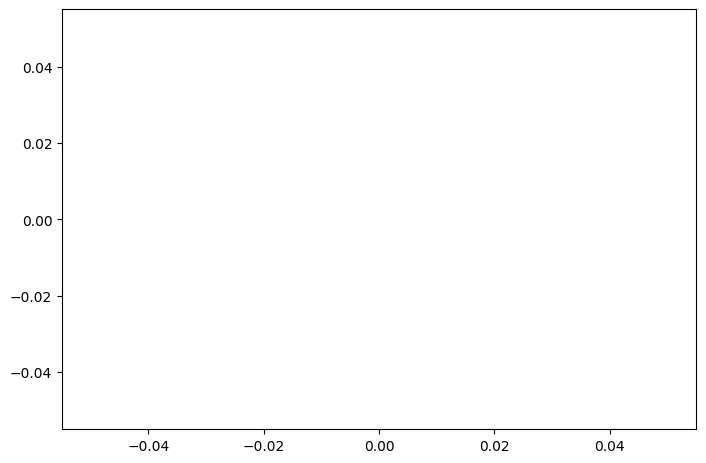

In [11]:
# Plotting
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.plot(epoch_count_list, train_loss_values, label='Train Loss', marker='o', linestyle='-')
plt.plot(epoch_count_list, val_loss_values, label='Validation Loss', marker='s', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epoch_count_list, train_acc_values, label='Train Char Accuracy', marker='o', linestyle='-')
plt.plot(epoch_count_list, val_acc_values, label='Validation Char Accuracy (Greedy)', marker='s', linestyle='--')
plt.title('Character Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Character Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("performance_plots.png")
plt.show()
print("Saved plots to performance_plots.png")